In [2]:
# import libraries and check versions
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(f'tensorflow version: {tf.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

# check tensorflow GPU device support
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('GPU present')
else:
    print('GPU absent')

tensorflow version: 2.6.0
pandas version: 1.3.2
numpy version: 1.20.3
seaborn version: 0.11.2
GPU present


2021-10-15 14:57:00.043987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-15 14:57:00.068787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-15 14:57:00.069044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


tensorflow version: 2.6.0
pandas version: 1.3.2
numpy version: 1.20.3
seaborn version: 0.11.2
GPU present


## Data Importing and Wrangling

In [3]:
# import dataset
import pickle
dataset = pickle.load(open('./datasets/RML2016.10a_dict.pkl', 'rb'), encoding='latin1')

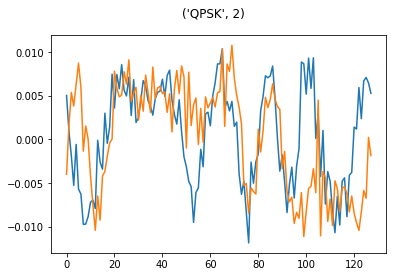

In [4]:
# plot dataset example
dataset_keys = list(dataset.keys())
x, y = dataset[dataset_keys[0]][1]

plt.figure(1)
plt.plot(x)
plt.plot(y)

plt.suptitle(dataset_keys[0])

plt.show()

In [5]:
# process raw data into usable format
columns = ['signal_type', 'SNR', 'samples']

# split dataset into individual records
temp = []
for k, v0 in dataset.items():
    data = [[k[0], k[1], v1] for v1 in v0]
    temp += data
    
# turn transformed data into dataframe
df = pd.DataFrame(temp, columns = columns)

# process dtypes of columns in dataframe
df = df.astype({'signal_type' : 'string'})

# filter out low SNR data
df = df[df['SNR'] >= 2]

print(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99000 entries, 0 to 218999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   signal_type  99000 non-null  string
 1   SNR          99000 non-null  int64 
 2   samples      99000 non-null  object
dtypes: int64(1), object(1), string(1)
memory usage: 3.0+ MB
None


,signal_type,SNR,samples
0,QPSK,2,"[[-0.0059014712, -0.0023458179, -0.00074506126..."
1,QPSK,2,"[[0.0050326153, 0.00094379985, -0.0018932355, ..."
2,QPSK,2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0..."


## EDA

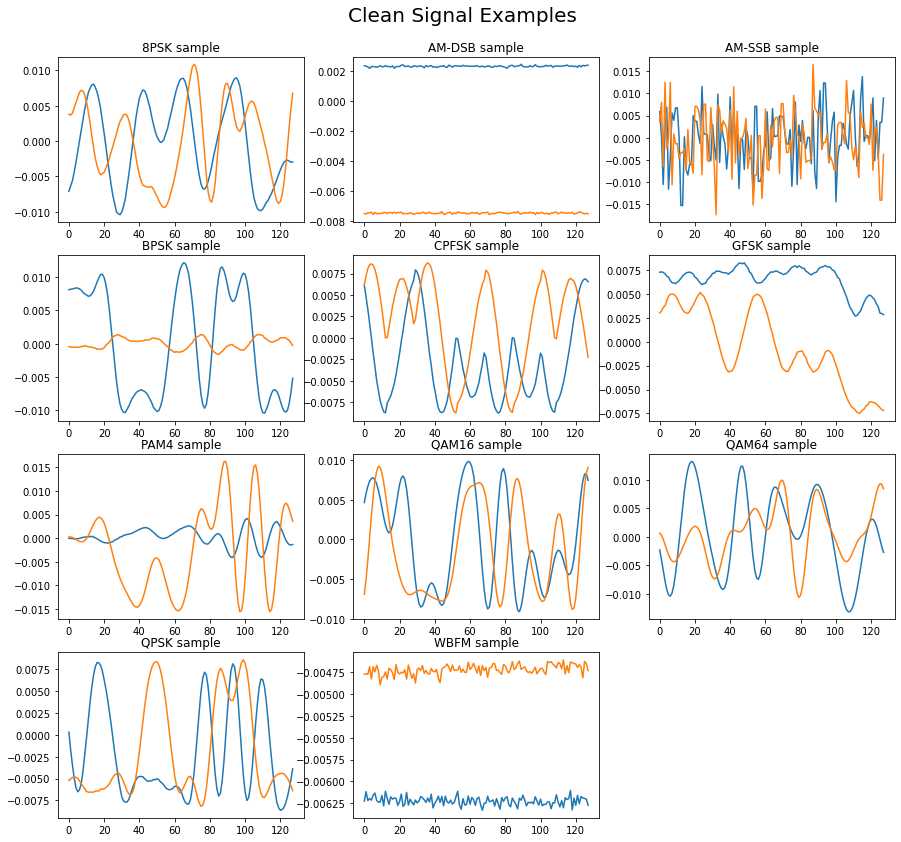

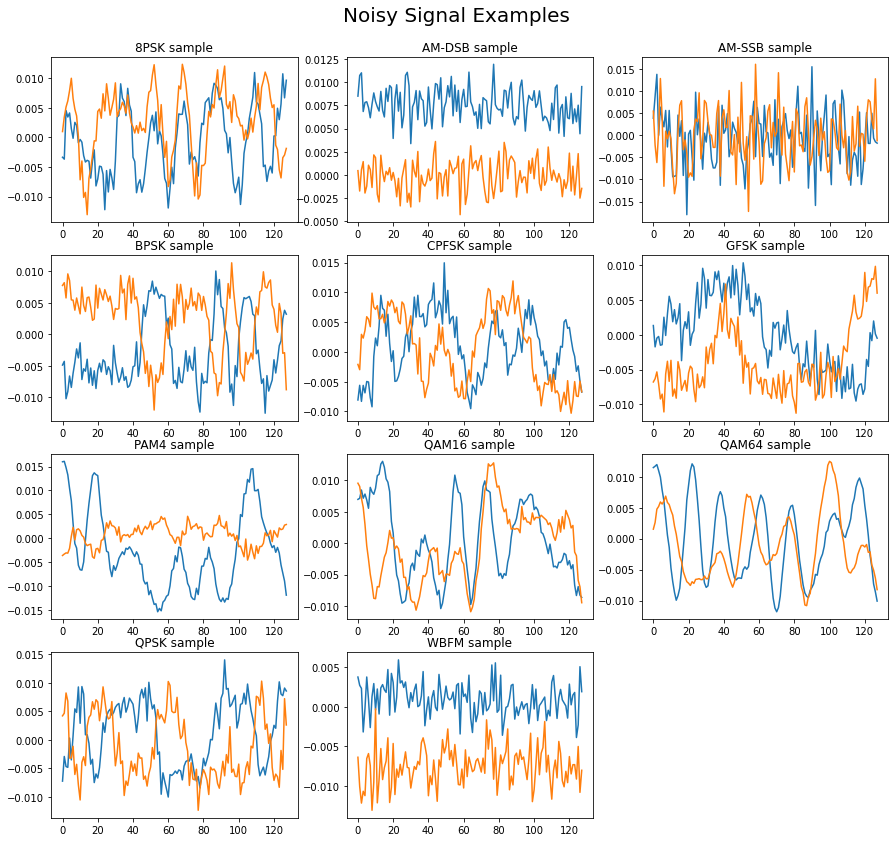

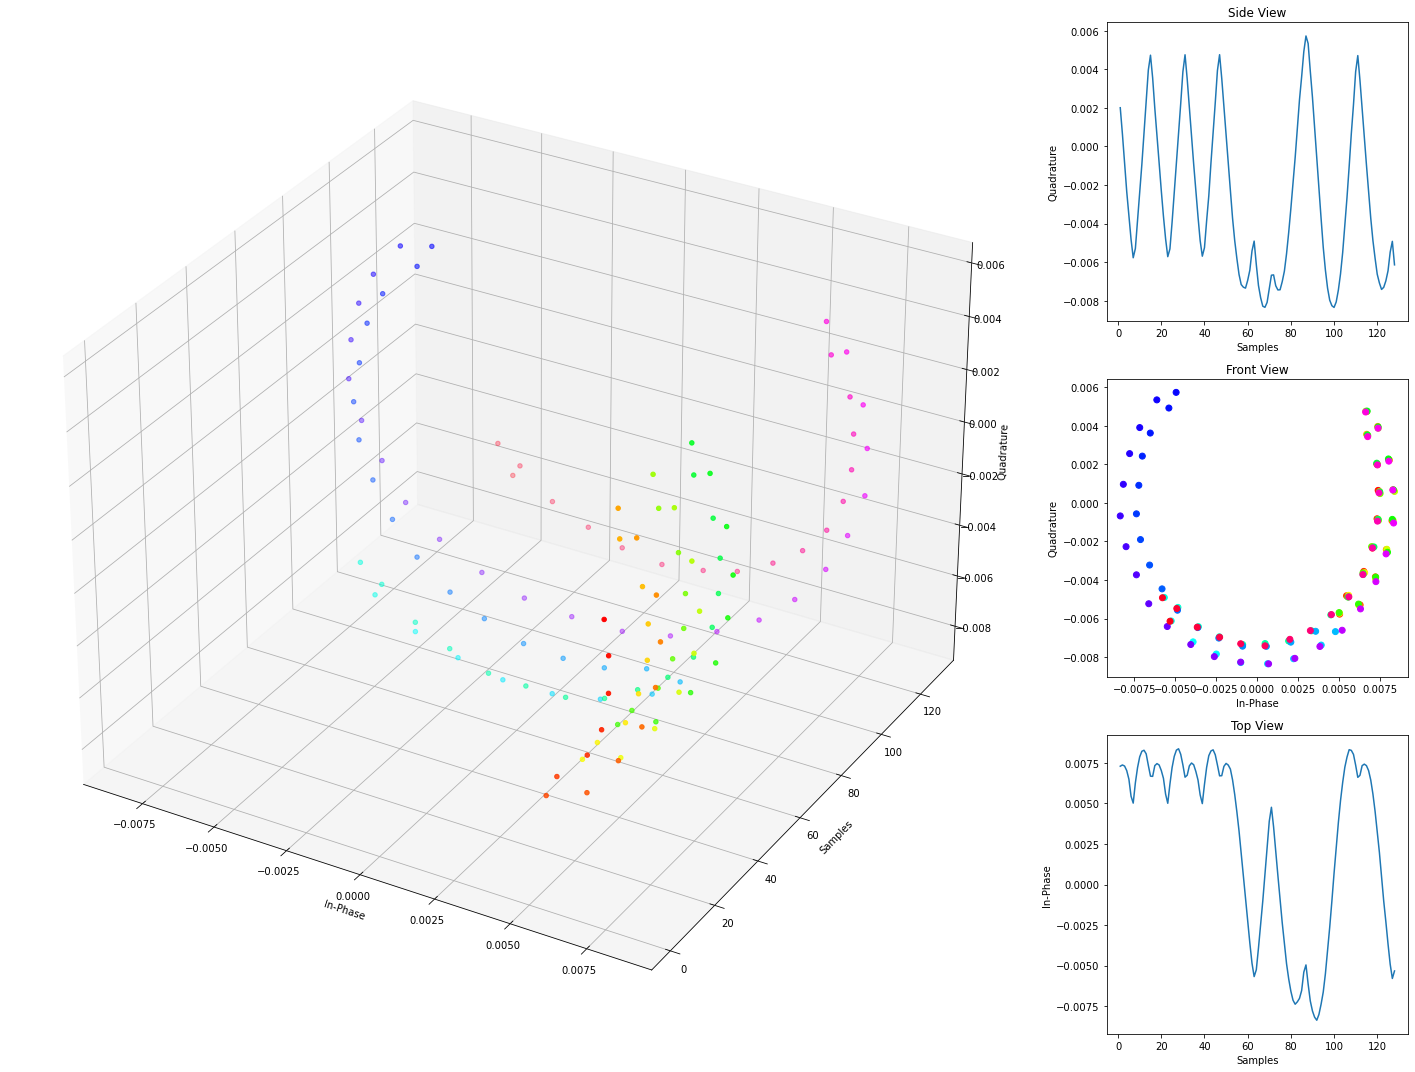

In [6]:
# plot out eda graphs
# plot out one of each clean signal
df_p1 = df[df['SNR'] == 18].sort_values('signal_type')
fig1 = plt.figure(figsize=(15, 14))
fig1.suptitle('Clean Signal Examples', y=0.93, fontsize=20)

for i, st in enumerate(df_p1['signal_type'].unique()):
    # extract random sample from plot df
    sample = df_p1[df_p1['signal_type'] == st]['samples'].sample().iloc[0]
        
    # generate axes
    ax = fig1.add_subplot(4, 3, i+1)
    
    # plot onto subplot
    ax.plot(sample[0])
    ax.plot(sample[1])
    
    ax.set_title(f'{st} sample')
    
# plot out one of each noisy signal
df_p2 = df[df['SNR'] == 2].sort_values('signal_type')
fig2 = plt.figure(figsize=(15, 14))
fig2.suptitle('Noisy Signal Examples', y=0.93, fontsize=20)

for i, st in enumerate(df_p2['signal_type'].unique()):
    # extract random example from plot df
    sample = df_p2[df_p2['signal_type'] == st]['samples'].sample().iloc[0]
    
    # generate axes
    ax = fig2.add_subplot(4, 3, i+1)
    
    # plot onto subplot
    ax.plot(sample[0])
    ax.plot(sample[1])
    
    ax.set_title(f'{st} sample')

# test plot
fig3 = plt.figure(figsize=(20, 15))
gs = fig3.add_gridspec(3, 4)
ax = fig3.add_subplot(gs[:3, :3], projection='3d')

x, z = df_p1[df_p1['signal_type'] == 'CPFSK']['samples'].sample().iloc[0]
y = np.arange(1, 129)

ax.scatter(x, y, z, c=y, cmap='hsv')
ax.set_xlabel('In-Phase')
ax.set_ylabel('Samples')
ax.set_zlabel('Quadrature')

# fig4 = plt.figure(figsize=(15, 5))

ax1 = fig3.add_subplot(gs[0, 3])
ax1.plot(y, z)
ax1.set_xlabel('Samples')
ax1.set_ylabel('Quadrature')
ax1.set_title('Side View')

ax2 = fig3.add_subplot(gs[1, 3])
ax2.scatter(x, z, c=y, cmap='hsv')
ax2.set_xlabel('In-Phase')
ax2.set_ylabel('Quadrature')
ax2.set_title('Front View')

ax3 = fig3.add_subplot(gs[2, 3])
ax3.plot(y, x)
ax3.set_xlabel('Samples')
ax3.set_ylabel('In-Phase')
ax3.set_title('Top View')


plt.tight_layout()
plt.show()

## Data Preparation for Training

In [6]:
# generate signal tags for classification
signal_tags = {st : tag for tag, st in enumerate(sorted(df['signal_type'].unique()))}

tag_list = [signal_tags[i] for i in df['signal_type'].values]
df['tag'] = tag_list

df.head(3)

,signal_type,SNR,samples,tag
0,QPSK,2,"[[-0.0059014712, -0.0023458179, -0.00074506126...",9
1,QPSK,2,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",9
2,QPSK,2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",9


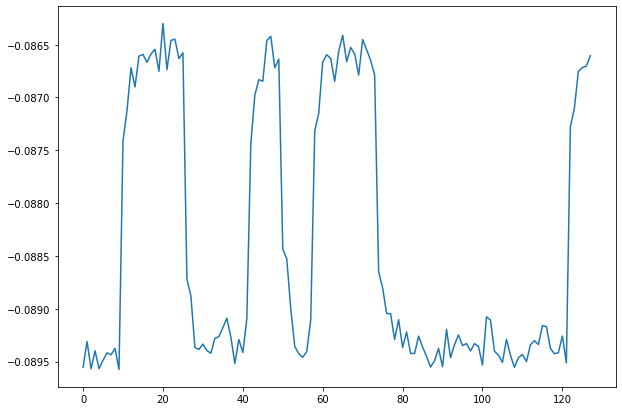

In [7]:
# generate power spectrum data
# EQ: P(dBm) = 10 * log(10 * (i**2 + q**2))

# magic numpy matrix operations
x, z = df_p1[df_p1['signal_type'] == 'CPFSK']['samples'].sample().iloc[0]
PdBm = 10 * np.log(10 * (x**2 + z**2))

plt.figure(figsize=(10, 7))
plt.plot(PdBm / np.linalg.norm(PdBm))

plt.show()

In [8]:
# extract 10 rows from each signal type for testing
df_train = df.copy()
df_test = pd.DataFrame([], columns = columns)

for st in df['signal_type'].unique():
    for snr in df['SNR'].unique():
        sample = df[df['signal_type'] == st][df['SNR'] == snr][:10]
        
        
        df_test = df_test.append(sample, ignore_index=True)        
        df_train.drop(sample.index.values, inplace=True)
        
df_test = df_test.astype({'tag' : 'int8'})

df_test.head(3)

/tmp/ipykernel_13231/70126845.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample = df[df['signal_type'] == st][df['SNR'] == snr][:10]


,signal_type,SNR,samples,tag
0,QPSK,2,"[[-0.0059014712, -0.0023458179, -0.00074506126...",9
1,QPSK,2,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",9
2,QPSK,2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",9


In [9]:
# scramble training dataset
df_train = df_train.sample(frac=1)

df_train.head(3)

,signal_type,SNR,samples,tag
96809,PAM4,18,"[[-0.001903513, -0.0015836019, -0.0011017689, ...",6
82590,QPSK,12,"[[-0.005987596, -0.006256244, -0.0059091016, -...",9
141728,WBFM,8,"[[-0.003652804, -0.0034391175, -0.0033570444, ...",10


In [10]:
# define one hot encode function
def one_hot(arr, n_cat):
    output = []
    for n in arr:
        result = np.zeros(n_cat)
        result[n] = 1

        output.append(result)

    return np.array(output, dtype=int)

In [11]:
# extract train and test data
X_train = np.concatenate(df_train['samples'].values).reshape((df_train.shape[0], 2, 128, 1))
y_train = one_hot(df_train['tag'].values, 11)

X_test = np.concatenate(df_test['samples'].values).reshape((df_test.shape[0], 2, 128, 1))
y_test = one_hot(df_test['tag'].values, 11)

## Model Training and Testing

In [12]:
# import model stuff
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, AveragePooling2D, concatenate, Dense, Input, UpSampling2D, Flatten

In [13]:
# functions for model segments
def block(x, s, p=1):
    '''
    function to construct the model's Block A residuals
    
    INPUT PARAMETERS
    x: layer to connect to.
    s: used to determine block type, can either be 1 or 2
    p: multiplication factor for kernel sizes, defaults to 1.
    '''
    assert s == 1 or s == 2

    a = Conv2D(filters=int(64 * p), kernel_size=1, strides=s, padding='same', activation='selu')(x)
    a = Conv2D(filters=int(64 * p), kernel_size=(3, 1), padding='same', activation='selu')(a)
    a = Conv2D(filters=int(128 * p), kernel_size=1, padding='same', activation='selu')(a)
    if s == 2:
        a = UpSampling2D(size=(1, 2))(a)
    
    x = concatenate([x, a])
        
    return x

In [14]:
# function to create main model
def create_model(in_dim, out_dim):
    '''
    function to construct the actual resnet model.

    INPUT PARAMETERS
    in_dim: dimensions of input
    out_dim: size of output
    '''

    input_layer = Input(in_dim)
    
    # stem section
    stem = Conv2D(filters=32, kernel_size=(31, 2), padding='same', activation='relu')(input_layer)
    stem = Conv2D(filters=48, kernel_size=(15, 2), padding='same', activation='relu')(stem)
    stem = Conv2D(filters=64, kernel_size=(7, 2), padding='same', activation='relu')(stem)
    stem = Conv2D(filters=64, kernel_size=(1, 2), padding='same', activation='relu')(stem)
    stem = MaxPool2D(pool_size=(3, 1), padding='same')(stem)
    
    # residual blocks
    block_param = [(2, 1), (1, 1), (2, 2), (1, 2), (1, 2), (2, 2), (1, 2), (1, 2), (2, 4), (1, 4), (1, 4), (1, 4), (2, 8), (1, 8)]
    rb = stem
    
    for (s, p) in block_param:
        rb = block(rb, s=s, p=p)
        
    # classification layers
    x = AveragePooling2D(pool_size=(1,  7), strides=7)(rb)
    x = Flatten()(x)

    output_layer = Dense(out_dim, activation='softmax')(x)

    # turn layers into model
    model = Model(inputs=input_layer, outputs=output_layer, name='deepres_rf_classification_model')

    return model

2021-10-14 10:49:08.861481: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-14 10:49:08.861869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-14 10:49:08.862178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-14 10:49:08.862469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

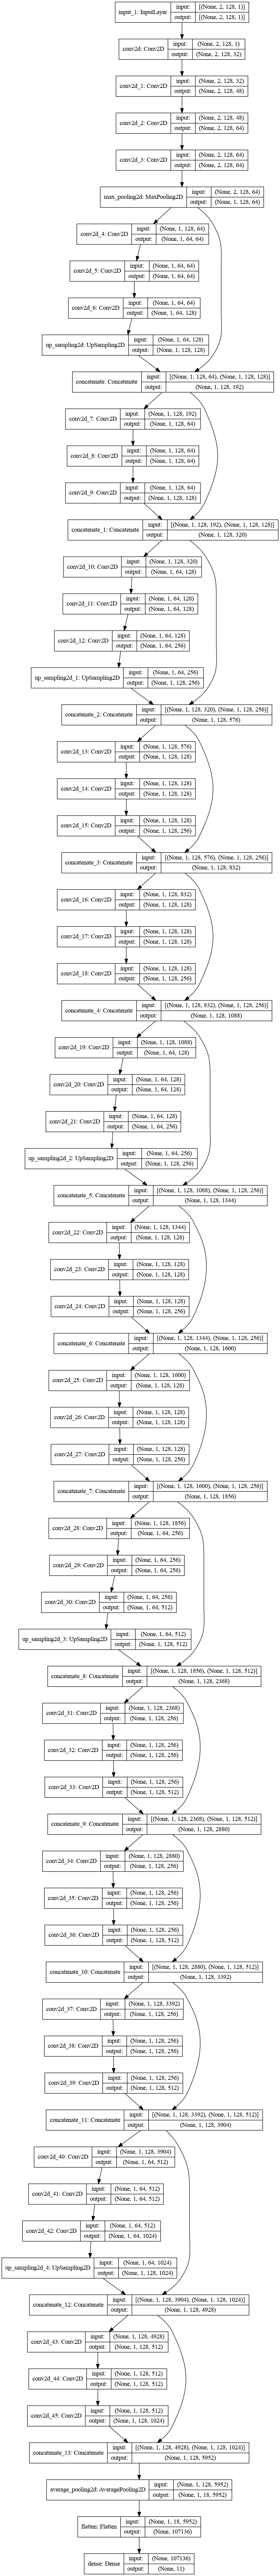

In [15]:
model = create_model((2, 128, 1), 11)

tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
model.summary()

Model: "deepres_rf_classification_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 128, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 2, 128, 32)   2016        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 2, 128, 48)   46128       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 2, 128, 64)   43072       conv2d_1[0][0]                   
____________________________________________________________________

In [17]:
# train model
# import metrics
# from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

#early stopping
callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

model.compile(optimizer=SGD(learning_rate=0.0005, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=50, callbacks=[callback], validation_split=0.2)

Epoch 1/50


2021-10-14 10:49:09.847489: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-14 10:49:11.421107: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-10-14 10:49:12.085452: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-14 10:49:12.085807: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-14 10:49:12.085823: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2021-10-14 10:49:12.086182: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-14 10:49:12.086213: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co

1569/1569 [==============================] - 137s 84ms/step - loss: 2.3994 - accuracy: 0.0922 - val_loss: 2.3992 - val_accuracy: 0.0901
Epoch 2/50
1569/1569 [==============================] - 131s 83ms/step - loss: 2.3987 - accuracy: 0.0910 - val_loss: 2.3991 - val_accuracy: 0.0921
Epoch 3/50
1569/1569 [==============================] - 135s 86ms/step - loss: 2.3986 - accuracy: 0.0887 - val_loss: 2.3981 - val_accuracy: 0.0931
Epoch 4/50
1569/1569 [==============================] - 143s 91ms/step - loss: 2.3985 - accuracy: 0.0886 - val_loss: 2.3988 - val_accuracy: 0.0923
Epoch 5/50
1569/1569 [==============================] - 143s 91ms/step - loss: 2.3984 - accuracy: 0.0906 - val_loss: 2.3986 - val_accuracy: 0.0890
Epoch 6/50
1569/1569 [==============================] - 141s 90ms/step - loss: 2.3983 - accuracy: 0.0910 - val_loss: 2.3985 - val_accuracy: 0.0901
Epoch 7/50
 238/1569 [===>..........................] - ETA: 1:43 - loss: 2.3984 - accuracy: 0.0890

KeyboardInterrupt: 

In [ ]:
# evaluate model performance on standard dataset
results = model.evaluate(X_test, y_test)

print(f'loss: {results[0]:.3f} | accuracy: {results[1]:.3f}')

In [ ]:
# plot out loss and accuracy graphs
train_hist = history.history

fig = plt.figure(1, figsize=(14, 7))

# loss graph
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(train_hist['loss'], label='training')
ax1.plot(train_hist['val_loss'], label='validation')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(b=True)

# accuracy graph
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(train_hist['accuracy'], label='training')
ax2.plot(train_hist['val_accuracy'], label='validation')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()
ax2.grid(b=True)

plt.show()

In [ ]:
# plot confusion matrices
cm_pred = model.predict(X_test)

# process results
temp = []
for row in cm_pred:
    temp.append(np.argmax(row))  
cm_pred = np.array(temp)

cm_truth = df_test['tag'].values

# generate matrix
tags = list(signal_tags.keys())
df_cm = pd.DataFrame(tf.math.confusion_matrix(cm_truth, cm_pred).numpy(), index=tags, columns=tags)

# plot matrix
fig = plt.figure(2, figsize=(10, 7))
ax = fig.add_axes([1, 1, 1, 1])
sns.heatmap(df_cm, annot=True, fmt='d', ax=ax)
ax.set_title('Prediction Confusion Matrix')

plt.show()

In [ ]:
# save model for future use
model.save('./saved_models/resnet_model')